## Imports

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from datetime import datetime
import pandas as pd
import numpy as np
import h5py
import json

## File paths

In [2]:
filename_overhang = '../MAMMUT-STARTHACK21/data/overhang/bae8f52c-407e-5f89-a8e3-61fcca51ee0a_raw.h5'
filename_traverse = '../MAMMUT-STARTHACK21/data/traverse/e897d166-1618-5bd3-ba3a-cb7577c64647_raw.h5'
filename_vertical = '../MAMMUT-STARTHACK21/data/vertical/40587108-e1a8-56ae-8c7f-1853f009b7c6_raw.h5'

## Functions use

In [108]:
def conver_df(filename):
    df = []
    with h5py.File(filename, "r") as f:
        columns = list(f.keys())
        for c in tqdm(columns):
            df.append(list(f[c]))

    df = pd.DataFrame(df).T
    df.columns = columns
    return df

def clean_df(df, name):
    data = []
    for j, (r,l) in enumerate(tqdm(list(zip(list(dict(df['acc_RH']).values()), list(dict(df['acc_LH']).values()))))):
        if r is not None:
            data.append([r[0], r[1], r[2], r[3], l[1], l[2], l[3], name])
    data = pd.DataFrame(data)
    data.columns = ['Time Step', 'Right AP', 'Right UR', 'Right DP', 'Left AP', 'Left UR', 'Left DP', 'Name']
    return data

def get_high(df):
    data = []
    for j, (r,l) in enumerate(tqdm(list(zip(list(dict(df['pres_RH']).values()), list(dict(df['pres_LH']).values()))))):
        if r is not None:
            data.append([r[0], r[2], l[2]])
    data = pd.DataFrame(data)
    data.columns = ['Time Step', 'pres RH', 'press UR']
    return data    

## Load data

In [109]:
df_overhang = clean_df(conver_df(filename_overhang), 'overhang')
df_traverse = clean_df(conver_df(filename_traverse), 'traverse')
#df_aux = conver_df(filename_traverse)
df_vertical = clean_df(conver_df(filename_vertical), 'vertical')

### Overhang

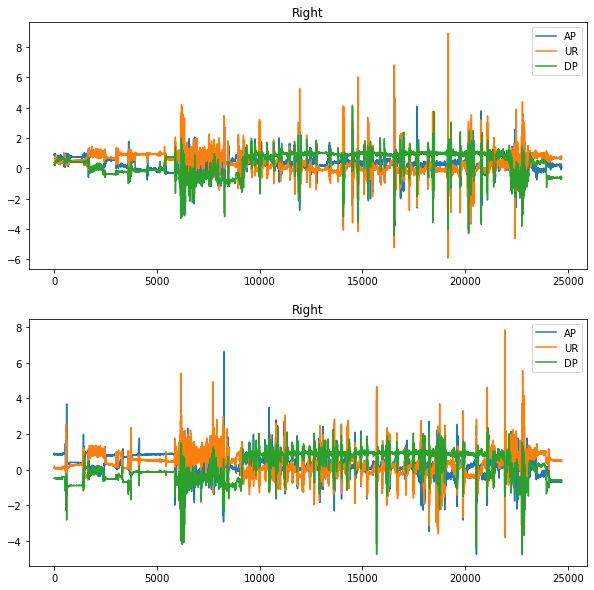

In [15]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Right')
plt.plot(df_overhang['Right AP'], label='AP')
plt.plot(df_overhang['Right UR'], label='UR')
plt.plot(df_overhang['Right DP'], label='DP')
plt.legend()

plt.subplot(2,1,2)
plt.title('Right')
plt.plot(df_overhang['Left AP'], label='AP')
plt.plot(df_overhang['Left UR'], label='UR')
plt.plot(df_overhang['Left DP'], label='DP')
plt.legend()

### Traverse

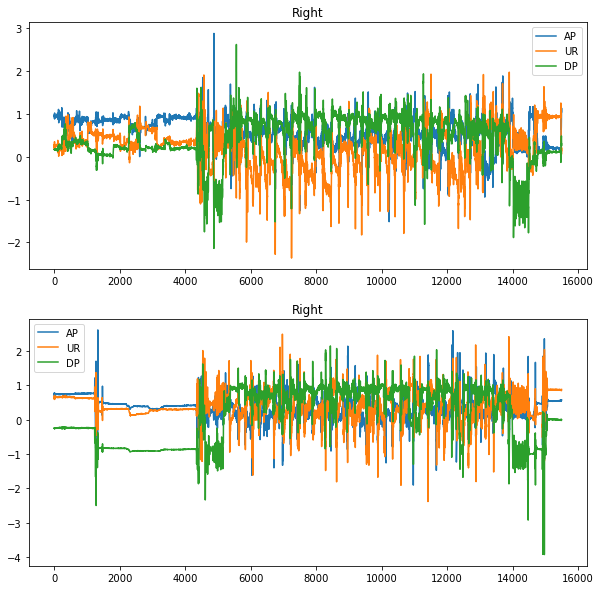

In [16]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Right')
plt.plot(df_traverse['Right AP'], label='AP')
plt.plot(df_traverse['Right UR'], label='UR')
plt.plot(df_traverse['Right DP'], label='DP')
plt.legend()

plt.subplot(2,1,2)
plt.title('Right')
plt.plot(df_traverse['Left AP'], label='AP')
plt.plot(df_traverse['Left UR'], label='UR')
plt.plot(df_traverse['Left DP'], label='DP')
plt.legend()

### Vertical

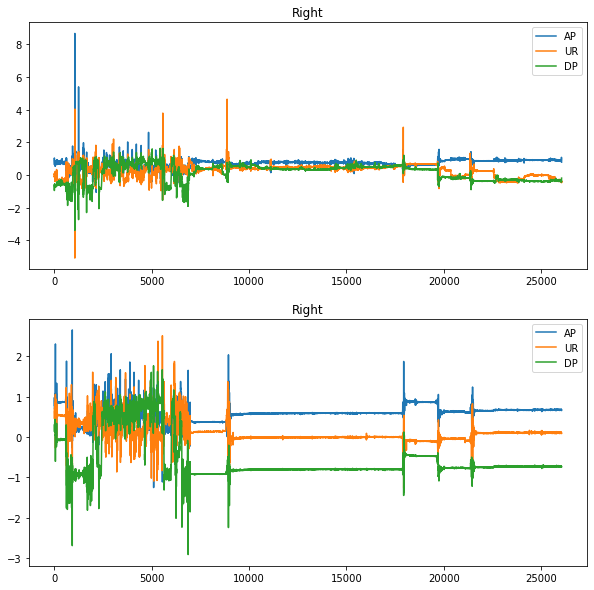

In [17]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Right')
plt.plot(df_vertical['Right AP'], label='AP')
plt.plot(df_vertical['Right UR'], label='UR')
plt.plot(df_vertical['Right DP'], label='DP')
plt.legend()

plt.subplot(2,1,2)
plt.title('Right')
plt.plot(df_vertical['Left AP'], label='AP')
plt.plot(df_vertical['Left UR'], label='UR')
plt.plot(df_vertical['Left DP'], label='DP')
plt.legend()

### Load json

In [110]:
path_traverse = 'datasets/traverse.json'
path_vertical = 'datasets/vertical.json'
path_vertical_horizontal = 'datasets/vertical_horizontal.json'

In [111]:
def get_json(path):
    f = open (path, "r") 

    # Reading from file 
    data = json.loads(f.read()) 

    position = []
    for d in data:
        aux = d['keypoints']
        p = [None, None, None, None]
        for a in aux:
            if a['part'] == 'leftShoulder':
                p[0] = [a['position']['x'], a['position']['y']]
            elif a['part'] == 'rightShoulder':
                p[1] = [a['position']['x'], a['position']['y']]
            elif a['part'] == 'leftWrist':
                p[2] = [a['position']['x'], a['position']['y']]
            elif a['part'] == 'rightWrist':
                p[3] = [a['position']['x'], a['position']['y']]
        position.append(p.copy())
    return pd.DataFrame(position, 
                        columns=['leftShoulder', 'rightShoulder', 'leftWrist', 'rightWrist'])

def process_json(df):
    df1 = pd.concat([pd.DataFrame(df[c].values.tolist()) for c in df.columns], 
                 axis=1, 
                 keys=df.columns)
    df1.columns = ['{}{}'.format(i, j) for i, j in df1.columns]

    col = df1.loc[: , ["leftShoulder0","rightShoulder0"]]
    df1['shoulder0'] = col.mean(axis=1)
    col = df1.loc[: , ["leftShoulder1","rightShoulder1"]]
    df1['shoulder1'] = col.mean(axis=1)

    left_wrist_norm0 = df1.loc[:, 'leftWrist0'] - df1.loc[: , 'shoulder0']
    right_wrist_norm0 = df1.loc[:, 'rightWrist0'] - df1.loc[: , 'shoulder0']
    left_wrist_norm1 = df1.loc[:, 'leftWrist1'] - df1.loc[: , 'shoulder1']
    right_wrist_norm1 = df1.loc[:, 'rightWrist1'] - df1.loc[: , 'shoulder1']

    df1['lwn0'] = left_wrist_norm0
    df1['rwn0'] = right_wrist_norm0
    df1['lwn1'] = left_wrist_norm1
    df1['rwn1'] = right_wrist_norm1

    return df1

def ajust(df_, json_):
    size_j = len(list(json_.index))
    size_df = len(list(df_.index))

    if size_j > size_df:
        index = np.zeros(size_j).astype(bool)
        index2 = np.ones(size_df).astype(bool)
        index[:len(index2)] = index2
        json_ = json_[index]
    else:
        index = np.zeros(size_df).astype(bool)
        index2 = np.ones(size_j).astype(bool)
        index[:len(index2)] = index2
        df_ = df_[index]
    return df_, json_

In [112]:
json_traveser = get_json(path_traverse)
json_vertical = get_json(path_vertical)
json_vertical_horizontal = get_json(path_vertical_horizontal) 

In [113]:
df_traverse_ = df_traverse[np.array(list(df_traverse.index)) % 43 == 0]
df_vertical_ = df_vertical[np.array(list(df_vertical.index)) % 69 == 0]
df_overhang_ = df_overhang[np.array(list(df_overhang.index)) % 46 == 0]

In [114]:
json_traveser_ = process_json(json_traveser)
json_vertical_ = process_json(json_vertical)
json_vertical_horizontal_ = process_json(json_vertical_horizontal) 

In [115]:
df_traverse_, json_traveser_ = ajust(df_traverse_, json_traveser_)
df_vertical_, json_vertical_ = ajust(df_vertical_, json_vertical_)
df_overhang_, json_vertical_horizontal_ = ajust(df_overhang_, json_vertical_horizontal_)

In [241]:
df_ = pd.concat([df_traverse_, df_vertical_, df_overhang_])
json_ = pd.concat([json_traveser_, json_vertical_, json_vertical_horizontal_])

In [117]:
ace = []

for i in dict(df_[['Right AP', 'Right UR', 'Right DP']]).values():
    ace.append(list(i))
    
ace2 = []
for j, i in enumerate(dict(df_[['Left AP', 'Left UR', 'Left DP']]).values()):
    ace[j] = ace[j] + list(i)
    
ace = ace + ace2
    
p = []
for j in dict(json_[['rwn0', 'rwn1']]).values():
    p.append(list(j))

p2 = []
for z, j in enumerate(dict(json_[['lwn0', 'lwn1']]).values()):
    p[z] = p[z] + list(j)

In [118]:
x = np.array(ace + p)
x = x[:, :x.shape[1] - 1]
x.shape

(5, 2533)

In [119]:
y = np.array(p)[:, 1:]
y.shape

(2, 2533)

## Model trainining

In [237]:
class predictor_hand():
    
    def __init__(self, max_iter=1000, tol=1e-3):
        self.reg = make_pipeline(StandardScaler(),
                                 SGDRegressor(max_iter=max_iter, tol=tol))
    
        self.reg2 = make_pipeline(StandardScaler(),
                                  SGDRegressor(max_iter=max_iter, tol=tol))
    
    def fit(self, x, y):
        self.reg.fit(x, y[0, :])

        self.reg2.fit(x, y[1, :])
        
        y_1 = self.reg2.predict(x)
        y_2 = self.reg.predict(x)
        print(y[1, :] - y_1)
        print("Absolute error y: {} x: {}".format(np.mean(abs(y[1, :] - y_1)),
               np.mean(abs(y[0, :] - y_2))))
        return np.array([y_2, y_1]).T
        
    def predict(self, x):
        return np.array([self.reg.predict(x), self.reg2.predict(x)]).T

       

In [238]:
model = predictor_hand()
prediction = model.fit(x.T, y)
#prediction = model.predict(x.T)

[ 20.80867382  20.91479168  20.807706   ...  72.20714068 -27.70101561
  -5.6011862 ]
Absolute error y: 40.109501275978204 x: 31.736333103247638


In [231]:
prediction 

array([[ 14.88578672,   7.26390755],
       [ 14.88541707,   7.28008504],
       [ 14.86614516,   7.21424082],
       ...,
       [  8.40688364, -13.40736474],
       [ -9.34889169,   6.26270315],
       [ -2.73801829, -16.77508731]])

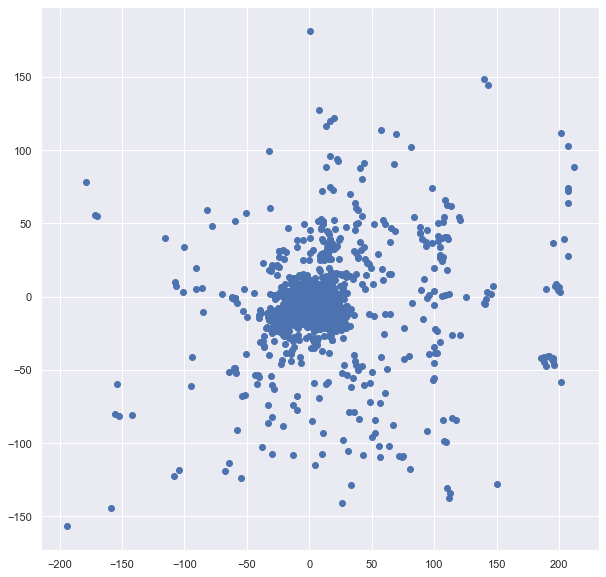

In [270]:
import seaborn as sns
sns.set()
plt.figure(figsize=(10,10))
plt.scatter(prediction[:, 0], prediction[:, 1])

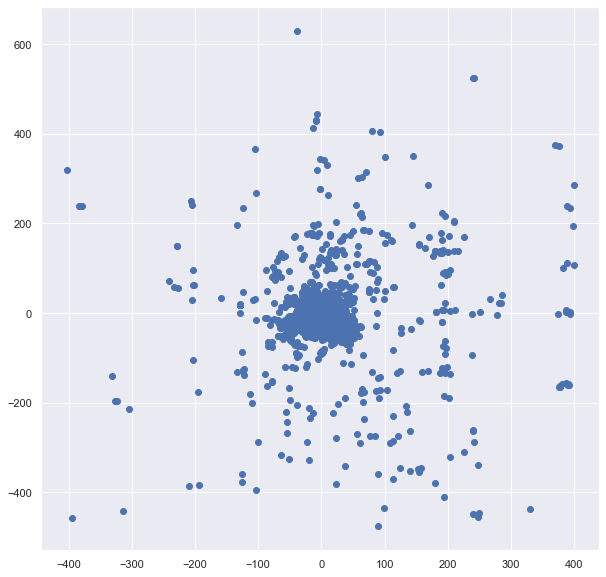

In [271]:
plt.figure(figsize=(10,10))
plt.scatter(y.T[:, 0], y.T[:, 1])

In [222]:
y.T[:, 0] - prediction[:, 0]

array([ 10.62648102,  10.58509691,  10.64894868, ..., -39.56678979,
        -5.13718612,  -6.18071941])

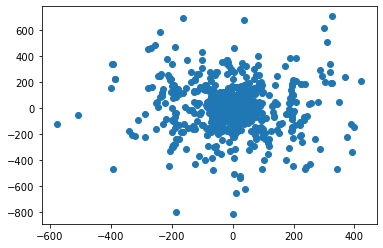

In [204]:
delta_pos = y.T - x.T[:, 3:]
plt.scatter(delta_pos[:,0], delta_pos[:,1])

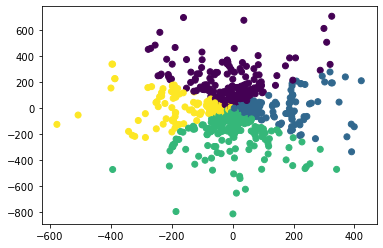

In [205]:
direction = np.array([0 if (delta_pos[i,0] < delta_pos[i,1] and -delta_pos[i,0] < delta_pos[i,1])
                      else 1 if (delta_pos[i,0] > delta_pos[i,1] and -delta_pos[i,0] < delta_pos[i,1])
                      else 2 if (delta_pos[i,0] > delta_pos[i,1] and delta_pos[i,0] < -delta_pos[i,1])
                      else 3 for i in range(len(delta_pos))])

plt.scatter(delta_pos[:,0], delta_pos[:,1], c = direction)

In [206]:
df_

,Time Step,Right AP,Right UR,Right DP,Left AP,Left UR,Left DP,Name,pres RH,press LR,prediction y,Rprediction y,Rprediction x,Lprediction y,Lprediction x,Rground y,Rground x,Lground y,Lground x
0,1.614259e+09,0.955107,0.252449,0.164556,0.734397,0.647969,-0.245613,traverse,0.000205,0.000065,6.730153,6.730153,12.290327,-14.505037,-5.981846,28.861992,23.314536,37.396618,-18.219024
43,1.614259e+09,0.944749,0.267524,0.167059,0.733912,0.647958,-0.247079,traverse,1.117139,0.990975,6.708150,6.708150,12.348923,6.765995,-8.150077,28.861992,23.314536,37.396618,-18.219024
86,1.614259e+09,0.954686,0.243708,0.152729,0.732446,0.648944,-0.254393,traverse,1.162757,0.399251,6.684657,6.684657,12.260801,6.760295,-8.151691,28.861992,23.314536,37.396618,-18.219024
129,1.614259e+09,1.037678,0.243218,0.222812,0.736847,0.647480,-0.239271,traverse,0.000126,0.018096,7.316729,7.316729,12.020549,6.740155,-8.165075,28.861992,23.314536,37.396618,-18.219024
172,1.614259e+09,0.981381,0.187608,0.234583,0.729515,0.643616,-0.245604,traverse,0.814070,1.248523,6.864594,6.864594,12.366688,6.791474,-8.144822,28.861992,23.314536,37.396618,-18.219024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24288,1.614261e+09,0.217434,0.710054,-0.641228,-0.661967,0.522370,-0.601393,overhang,0.511823,0.024195,-3.839713,-3.839713,-10.427595,-1.174150,9.727748,-18.113838,5.314108,8.145079,1.083292
24334,1.614261e+09,0.200935,0.628583,-0.641287,-0.655251,0.536273,-0.590726,overhang,0.405073,0.129429,-11.357913,-11.357913,4.446918,-9.912002,7.418254,-27.529280,0.242369,-16.916772,10.497154
24380,1.614261e+09,0.165917,0.667389,-0.631067,-0.672652,0.552565,-0.597217,overhang,0.014926,0.415544,-14.085260,-14.085260,2.037232,-16.219464,11.730320,-22.466108,-18.888029,52.842445,-27.613808
24426,1.614261e+09,0.178207,0.641150,-0.624380,-0.663085,0.507444,-0.589335,overhang,0.956464,0.306078,-13.212706,-13.212706,-7.359079,1.212457,-6.089347,-28.317448,-15.634259,-27.845502,-10.358023


## Wrap everything

In [127]:
h_overhang = get_high(conver_df(filename_overhang))
h_traverse = get_high(conver_df(filename_traverse))
h_vertical = get_high(conver_df(filename_vertical))

In [174]:
h_traverse_ = h_traverse[np.array(list(h_traverse.index)) % 43 == 0]
h_vertical_ = h_vertical[np.array(list(h_vertical.index)) % 69 == 0]
h_overhang_ = h_overhang[np.array(list(h_overhang.index)) % 46 == 0]

h_traverse_, _ = ajust(h_traverse_, json_traveser_)
h_vertical_, _ = ajust(h_vertical_, json_vertical_)
h_overhang_, _ = ajust(h_overhang_, json_vertical_horizontal_)

In [175]:
h = pd.concat([h_traverse_, h_vertical_, h_overhang_])[['pres RH', 'press UR']]

In [250]:
df_['pres RH'] = h['pres RH']
df_['press LR'] = h['press UR']
df_['Rprediction y'] = prediction[:int(len(prediction)/2) + 1][:,1]
df_['Rprediction x'] = prediction[:int(len(prediction)/2) + 1][:,0]
df_['Lprediction y'] = prediction[int(len(prediction)/2):][:,1]
df_['Lprediction x'] = prediction[int(len(prediction)/2):][:,0]
df_['Rdirection '] = direction[:int(len(prediction)/2) + 1]
df_['Ldirection '] = direction[int(len(prediction)/2):]

In [251]:
df_

,Time Step,Right AP,Right UR,Right DP,Left AP,Left UR,Left DP,Name,pres RH,press LR,Rprediction y,Rprediction x,Lprediction y,Lprediction x,Rdirection,Ldirection
0,1.614259e+09,0.955107,0.252449,0.164556,0.734397,0.647969,-0.245613,traverse,0.000205,0.000065,8.053318,12.021670,-17.260687,-5.585441,3,0
43,1.614259e+09,0.944749,0.267524,0.167059,0.733912,0.647958,-0.247079,traverse,1.117139,0.990975,7.947200,12.091085,6.449830,-7.712861,3,3
86,1.614259e+09,0.954686,0.243708,0.152729,0.732446,0.648944,-0.254393,traverse,1.162757,0.399251,8.054286,12.001792,6.444491,-7.713128,3,3
129,1.614259e+09,1.037678,0.243218,0.222812,0.736847,0.647480,-0.239271,traverse,0.000126,0.018096,8.763997,11.569029,6.422999,-7.722616,3,3
172,1.614259e+09,0.981381,0.187608,0.234583,0.729515,0.643616,-0.245604,traverse,0.814070,1.248523,8.464183,12.074800,6.476647,-7.713792,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24288,1.614261e+09,0.217434,0.710054,-0.641228,-0.661967,0.522370,-0.601393,overhang,0.511823,0.024195,-5.657084,-9.271027,-2.701697,13.229312,1,2
24334,1.614261e+09,0.200935,0.628583,-0.641287,-0.655251,0.536273,-0.590726,overhang,0.405073,0.129429,-13.624971,4.923555,-12.312894,10.348105,2,2
24380,1.614261e+09,0.165917,0.667389,-0.631067,-0.672652,0.552565,-0.597217,overhang,0.014926,0.415544,-16.860326,2.415123,-19.364696,14.098088,3,0
24426,1.614261e+09,0.178207,0.641150,-0.624380,-0.663085,0.507444,-0.589335,overhang,0.956464,0.306078,-15.756793,-6.767100,-0.144487,-2.125399,2,2


In [264]:
df_.to_csv('data.csv')

In [262]:
with open('data.json', 'w') as f:
    json.dump(dict(df_), f)

TypeError: Object of type Series is not JSON serializable

In [172]:
h_vertical_

,Time Step,pres RH,press UR
0,1.614260e+09,0.000267,0.000149
69,1.614260e+09,0.336433,0.430195
138,1.614260e+09,0.526251,1.990557
207,1.614260e+09,1.408424,0.028473
276,1.614260e+09,0.943374,0.441437
...,...,...,...
25737,1.614260e+09,0.794394,0.382272
25806,1.614260e+09,0.524976,1.043604
25875,1.614260e+09,0.231834,0.379757
25944,1.614260e+09,0.839274,1.219499


In [191]:
len(prediction[int(len(prediction)/2):][:,0])

1267